In [202]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.svm import OneClassSVM

In [203]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
import copy

In [204]:
altitude = 121.92
fov = 100
angle = fov/2
width_multiplier = 2 * np.tan(np.radians(angle))
height_multiplier = (3 * width_multiplier)/4

In [205]:
image_path = "map_sq.png"
map_img = cv2.imread(image_path)
img_sz = map_img.shape[0]
map_sz = 1200
resolution = img_sz/map_sz

In [206]:
def state_to_pixel(state):
    predicted_x, predicted_y = state
    predicted_x_px = int((img_sz/2) + (resolution * predicted_x))
    predicted_y_px = int((img_sz/2) + (resolution * predicted_y))
    return predicted_x_px, predicted_y_px

In [207]:
def generate_predicted_image(state, img):
    # Generate predicted image based on particle state
    predicted_x_px, predicted_y_px = state_to_pixel(state)
    img_width = (altitude * width_multiplier)
    img_height = (altitude * height_multiplier)
    if img_width>0:
        return cv2.rotate(img[predicted_x_px-int(img_width/2):predicted_x_px+int(img_width/2),
                   predicted_y_px-int(img_height/2):predicted_y_px+int(img_height/2)], cv2.ROTATE_90_COUNTERCLOCKWISE)   # Assuming a 100x100 crop
    else:
        return None

In [208]:
def imshow(test):
    test1 = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
    plt.imshow(test1)
    plt.show()

In [217]:
first = generate_predicted_image((0,0), map_img)
second = generate_predicted_image((0,5), map_img)
third = generate_predicted_image((300,40), map_img)

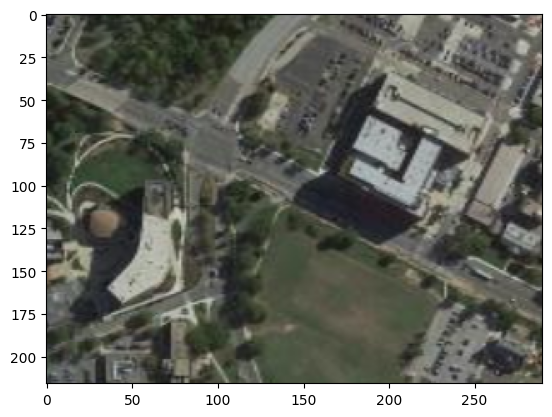

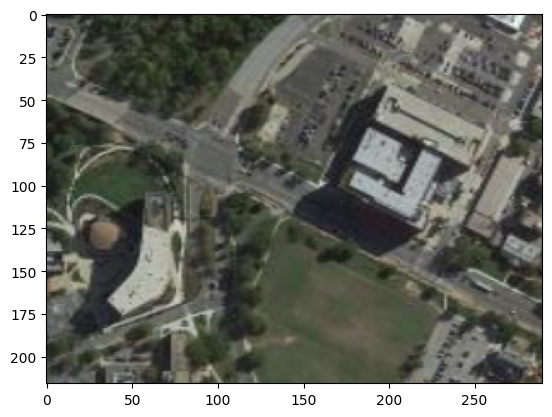

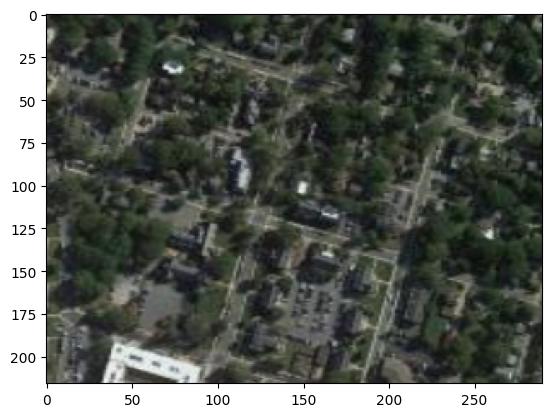

In [210]:
imshow(first)
imshow(second)
imshow(third)

In [211]:
def get_kp(img): 
    # Converting image to grayscale
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Applying SIFT detector
    sift = cv2.SIFT_create()
    kp = sift.detect(gray, None)
    return kp

In [212]:
kp1 = get_kp(first)
kp2 = get_kp(second)
kp3 = get_kp(third)

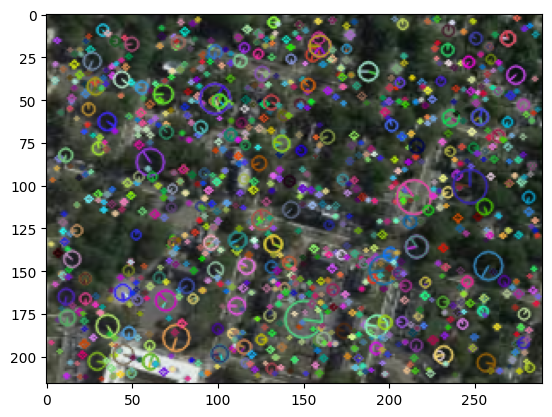

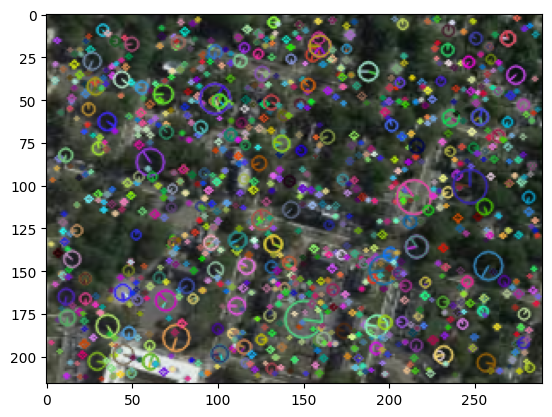

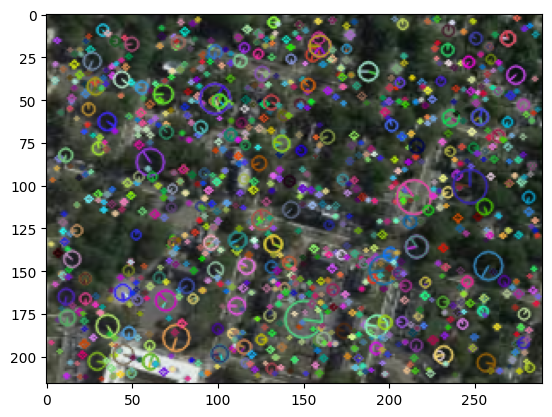

In [213]:
imgkp1 = cv2.drawKeypoints(first, kp1, first, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imgkp2 = cv2.drawKeypoints(second, kp2, first, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imgkp3 = cv2.drawKeypoints(third, kp3, first, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

imshow(imgkp1)
imshow(imgkp2)
imshow(imgkp3)


In [214]:
pts1 = cv2.KeyPoint_convert(kp1)
pts2 = cv2.KeyPoint_convert(kp2)
pts3 = cv2.KeyPoint_convert(kp3)

print(pts1.shape, pts2.shape, pts3.shape)

(983, 2) (965, 2) (1210, 2)


In [215]:
class Encoder:

    def __init__(self):
        self.d = 1024
        self.alpha = 0.1
        self.W = np.stack([self.strict_standard_normal(self.d) for _ in range(2)], axis=0) * self.alpha
        self.detector = cv2.SIFT_create()
        
    def strict_standard_normal(self, d):
        y = np.linspace(0, 1, d+2)
        x = norm.ppf(y)[1:-1]
        np.random.shuffle(x)
        return x
    
    def encode(self, img):
        kp = self.detector.detect(img, None)
        pts = cv2.KeyPoint_convert(kp)
        print(pts.shape)
        Z = np.exp(1j * pts @ self.W).sum(axis=0)
        Z = Z / np.linalg.norm(Z)
        return Z

    def similarity(self, x, y):
        return np.absolute(np.sum(x * y.conj()))
    


(983, 2)
(965, 2)
(1210, 2)
[1.         0.         0.00171657]


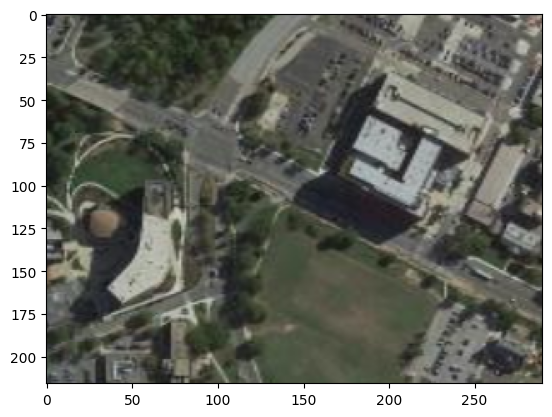

In [221]:
E = Encoder()
# You can do fast encoding.
v_1 = E.encode(cv2.cvtColor(first, cv2.COLOR_BGR2GRAY))
v_2 = E.encode(cv2.cvtColor(second, cv2.COLOR_BGR2GRAY))
v_3 = E.encode(cv2.cvtColor(third, cv2.COLOR_BGR2GRAY))

arr = np.array([E.similarity(v_1, v_2), E.similarity(v_2, v_3), E.similarity(v_1, v_3)])

norm_arr = (arr - min(arr))/ (max(arr)-min(arr))

print(norm_arr)

imshow(first)